### 基于KdTree的KNN实现

In [1]:
import numpy as np
from scipy.spatial import distance
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_iris

In [2]:
class Node:
    def __init__(self, x, y, depth=0, lchild=None, rchild=None):
        self.x = x
        self.y = y
        self.depth = depth
        self.lchild = lchild
        self.rchild = rchild

In [3]:
class KdTree:
    def __init__(self, X, y):
        assert len(X) == len(y)
        train = np.concatenate([X, y[:, np.newaxis]], axis=1)
        
        def build_tree(train, depth=0):
            if (len(train) > 0):
                m, n = train.shape
                axis = depth % (n - 1)
                mid = m // 2
                train = np.array(sorted(train, key=lambda x: x[axis]))
                node = Node(train[mid][:-1], train[mid][-1], depth)
                node.lchild = build_tree(train[:mid], depth+1)
                node.rchild = build_tree(train[mid+1:], depth+1)
                return node
            return None
        
        self.root = build_tree(train)
        self.n = X.shape[1]
        self._count = 0
        
    def knn(self, x, k=1):
        nearest = [[-1, None] for _ in range(k)]
        self._count = 0
        def search(node):
            if node is not None:
                axis = node.depth % self.n
                daxis = x[axis] - node.x[axis]
                if daxis <= 0:
                    search(node.lchild)
                else:
                    search(node.rchild)
                    
                dist = distance.euclidean(x, node.x)
                for i, d in enumerate(nearest):
                    if d[0] < 0 or dist < d[0]:
                        nearest.insert(i, [dist, node])
                        nearest.pop()
                        self._count += 1
                        break
                
                if self._count < k or nearest[-1][0] > abs(daxis):
                    if daxis <= 0:
                        search(node.rchild)
                    else:
                        search(node.lchild)
                        
        search(self.root)
        return nearest

In [4]:
iris = load_iris()

In [5]:
data = pd.DataFrame(iris.data, columns=iris.feature_names)

In [6]:
data.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


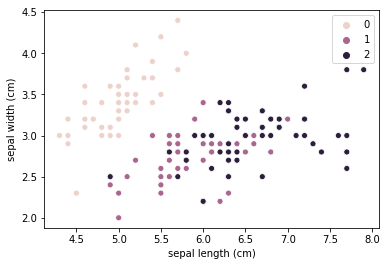

In [7]:
sns.scatterplot(x='sepal length (cm)', y='sepal width (cm)', hue=iris.target, data=data)

In [8]:
kdtree = KdTree(iris.data, iris.target)
x = [5., 3.25, 1.4, 0.2]
nearest = kdtree.knn(x, 5)

[5.  3.3 1.4 0.2] dist: 0.04999999999999982
[5.  3.4 1.5 0.2] dist: 0.18027756377319945
[5.1 3.4 1.5 0.2] dist: 0.20615528128088284
[4.9 3.1 1.5 0.2] dist: 0.20615528128088284
[5.  3.2 1.2 0.2] dist: 0.20615528128088295


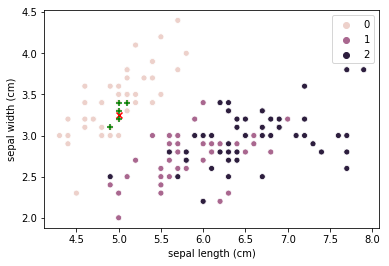

In [9]:
cat = {}
sns.scatterplot(x='sepal length (cm)', y='sepal width (cm)', hue=iris.target, data=data)
plt.scatter(x[0], x[1], c='red', marker='x')
for n in nearest:
    print(n[1].x, "dist:", n[0])
    if n[1].y not in cat:
        cat[n[1].y] = 1
    else:
        cat[n[1].y] += 1
    plt.scatter(n[1].x[0], n[1].x[1], c='green', marker='+')

In [10]:
max(cat)

0.0